In [2]:
!pip install lazypredict-nightly

In [22]:
import pandas as pd
import lazypredict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from lazypredict import LazyRegressor
from sklearn.utils import shuffle
from scipy.ndimage import gaussian_filter1d
import lightgbm as lgb
import logging

In [23]:
# Loading the data
df = pd.read_csv('/content/final_data_exchange_bias.csv')
df = df.drop(columns=['core', 'shell', 'formula'])

# Preprocessing the target variable
y = df['exc_bias_oe']
y = y[y > 0]  # Keep only positive values

# Smoothing the target variable
y_smooth = gaussian_filter1d(y, sigma=2)  # Adjust sigma to control the smoothing degree

# Logarithm of the smoothed target variable
y_log = np.log10(y_smooth)

# Forming the feature set
X = df[df['exc_bias_oe'] > 0].drop(columns=['exc_bias_oe'])

# Applying KNN Imputer to fill missing values
knn_imputer = KNNImputer(n_neighbors=5)
X_imputed = knn_imputer.fit_transform(X)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_log, test_size=0.2, random_state=1984)

In [24]:
# Set LightGBM to silent mode
lgb_params = {
    'verbose': -1,  # This will suppress most of the output
    'force_row_wise': True  # You can also add this to avoid overhead warning
}

# Additionally, suppress LightGBM logging explicitly
logger = logging.getLogger('lightgbm')
logger.setLevel(logging.ERROR)  # Only display errors

# Example LightGBM model call
model = lgb.LGBMRegressor(**lgb_params)
model.fit(X_train, y_train)

LGBMRegressor(force_row_wise=True, verbose=-1)

In [25]:
# Scaling the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating LazyRegressor
reg = LazyRegressor(predictions=True)
print("LazyRegressor created.")

LazyRegressor created.


In [28]:
# Training and testing the models
models, predictions = reg.fit(X_train_scaled, X_test_scaled, y_train, y_test)
print("Model fitting complete.")

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████| 42/42 [00:12<00:00,  3.34it/s]

Model fitting complete.


Models found.
Results saved to lazy_regressor_results.csv
Results loaded successfully from lazy_regressor_results.csv:
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.73       0.78  0.22        1.07
XGBRegressor                                 0.64       0.71  0.26        0.73
LGBMRegressor                                0.61       0.69  0.27        0.16
RandomForestRegressor                        0.61       0.68  0.27        2.90
HistGradientBoostingRegressor                0.61       0.68  0.27        0.45
BaggingRegressor                             0.56       0.65  0.28        0.24
GradientBoostingRegressor                    0.54       0.63  0.29        0.81
KNeighborsRegressor                          0.42       0.53  0.33        0.02
ExtraTreeRegressor                           0.40       0.51  0.33        0.04
SVR         

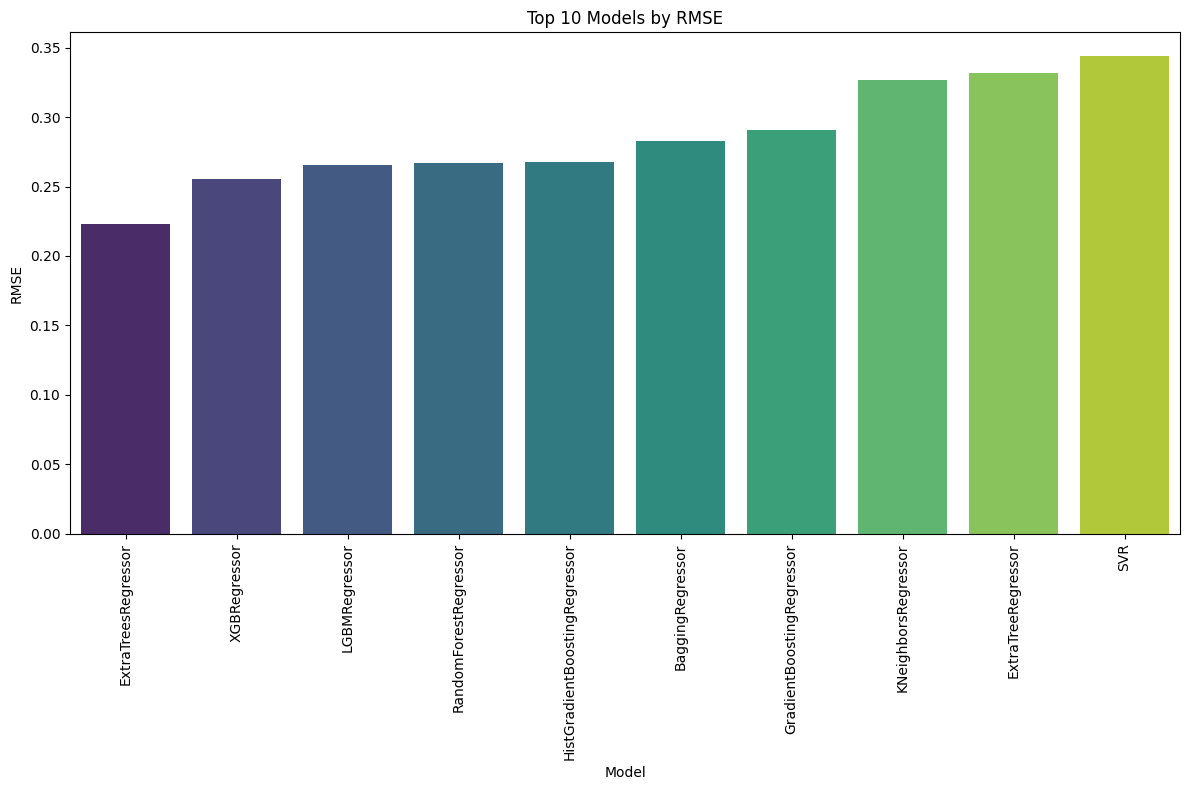

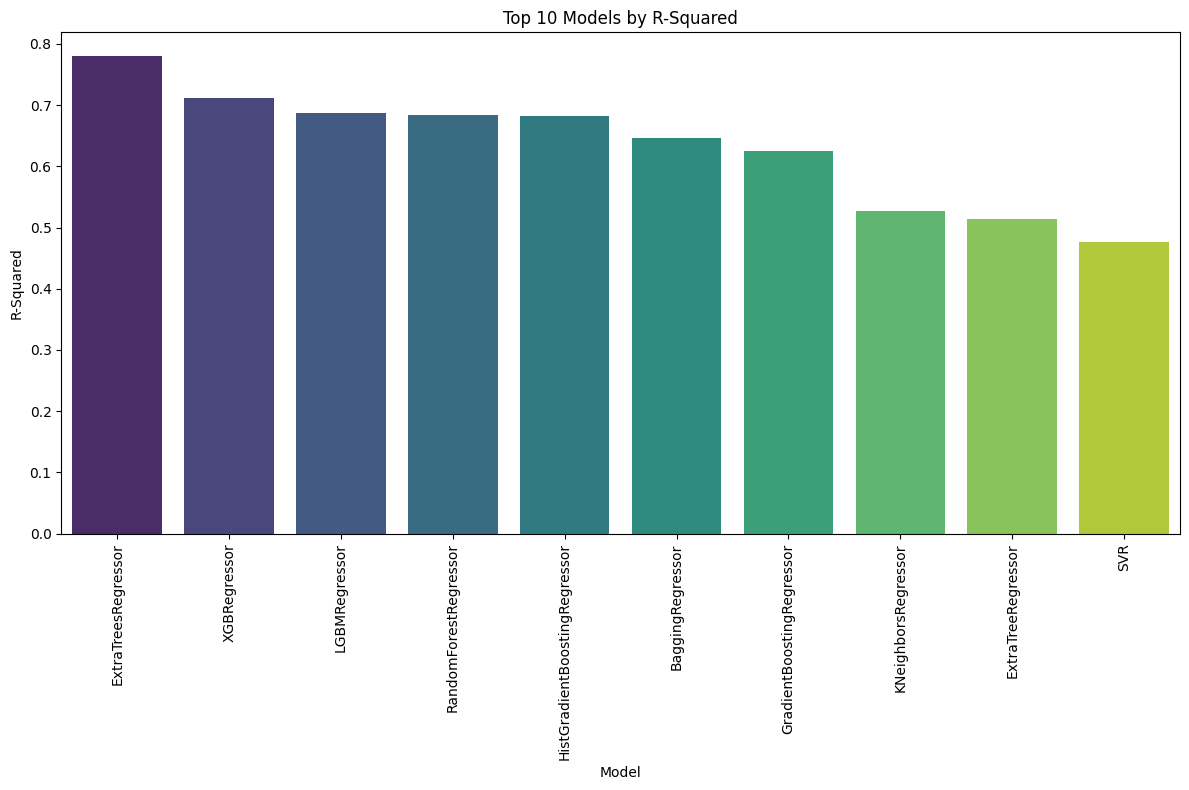

In [29]:
# Checking the results
if not models.empty:
    print("Models found.")

    # Saving the results to a CSV file
    models.to_csv('lazy_regressor_results.csv', index=True)
    print("Results saved to lazy_regressor_results.csv")

    # Loading the results from the CSV file
    loaded_results = pd.read_csv('lazy_regressor_results.csv', index_col=0)
    print("Results loaded successfully from lazy_regressor_results.csv:")
    print(loaded_results)

    # Visualizing the top 10 models by RMSE
    plt.figure(figsize=(12, 8))
    top_10_rmse = models.sort_values(by='RMSE').head(10)
    sns.barplot(x=top_10_rmse.index, y='RMSE', data=top_10_rmse, palette='viridis')
    plt.xticks(rotation=90)
    plt.title('Top 10 Models by RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('Model')
    plt.tight_layout()
    plt.show()

    # Visualizing the top 10 models by R-Squared
    plt.figure(figsize=(12, 8))
    top_10_r2 = models.sort_values(by='R-Squared', ascending=False).head(10)
    sns.barplot(x=top_10_r2.index, y='R-Squared', data=top_10_r2, palette='viridis')
    plt.xticks(rotation=90)
    plt.title('Top 10 Models by R-Squared')
    plt.ylabel('R-Squared')
    plt.xlabel('Model')
    plt.tight_layout()
    plt.show()
else:
    print("No models found.")